In [ ]:
 # What influences Airbnb prices? Does property description tell us about rent price? Random forest vs. light gradient boosting.
#Katrina Hramovich

# Outline

1. Introduction 
2. What month has the highest rent prices?
3. What other features can be important for prices prediction?
4. What performs better Random Forest or Light Gradient Boosting? 
5. Do prices correlate with property description text? Mixed model.
6. Conclusion


In [ ]:
# Introduction

#Airbnb day prices in Seattle are predicted using feature engineering, random forest and light gradient boosting feature selection and regression. These models aim to help hosts establish appropriate rental prices and also to find out what features can influence rental price the most. Text features such as name and description are also considered. 
#Here we also compare random forest and light gradient boosting performance. Light Gradient Boosting (LGB) is relatively fast algorithm comparing with other boosting methods. In the final test the sum of two LGB models was applied to reduce overfitting. Final best R2 score on test is 0.736
#Data are downloaded from https://www.kaggle.com/airbnb/seattle
#Notebook with code is at https://github.com/KatrinaHramovich/Airbnb-modeling-project

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMModel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import scipy
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.ensemble import RandomForestRegressor

In [46]:
df=pd.read_csv("listings.csv")
dfcal=pd.read_csv("calendar.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [47]:
dfcal['month']=dfcal['date'].apply(lambda x: int(x.split('-')[1]))
dfcal=dfcal.rename(columns={'listing_id': 'id'})
dfcal=dfcal[['id', 'month', 'price']].copy()

In [48]:
df['price']=df['price'].apply(lambda x: float(x[1:].replace(',','')))
dfcal=dfcal.dropna()
dfcal['price']=dfcal['price'].apply(lambda x: float(x[1:].replace(',','')))

In [49]:
mp = dfcal[['month', 'price']].groupby('month').mean()

In [50]:
#It is important to remove duplicates at the end. If we get duplicates in test and train after spliting it will show better result compared
#to the case if we get new test set without duplicates. It can be misleading as overfitting.
dfcal=dfcal.dropna()
dfcal=dfcal.drop_duplicates()
dfcal.head()

,id,month,price
0,241032,1,85.0
28,241032,2,85.0
57,241032,3,85.0
88,241032,4,85.0
118,241032,5,85.0


Model evaluation function fits training data, predicts and computes score

In [51]:
def model_eval(X_train, y_train, X_test, y_test, model):
    '''
    input: X is features data frame, y is respones, model
    output: train cross validation score, test score, predicted values
    
    '''
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    score = cross_val_score(model, X_train, y_train, scoring = 'r2', cv = 5)
    test_score = r2_score(y_test, y_pred)
    return score, test_score, y_pred

def plot_dist(col):
    '''
    plot distribution of feature in column col
    '''
    dfc=df[['id', col]].groupby([col]).count()
    (dfc/df.shape[0]).plot(kind="bar");
def plot_features(X, model, name):
    '''
    plot random forest features importance
    input: dataframe X and regression model
    output: Feature importance plot
    '''
    print("Plot feature importances…")
    headers = ["name", "score"]
    values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    forest_feature_importances = pd.DataFrame(values, columns = headers)
    forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)
    features = forest_feature_importances['name'][:25]
    y_pos = np.arange(len(features))
    scores = forest_feature_importances['score'][:25]
    #plot feature importances
    plt.figure(figsize=(10,5))
    plt.bar(y_pos, scores, align='center', alpha=0.5)
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances' + name)
    plt.show()
def tfidf_text_transform(df_train, df_test, max_features):
    '''
    input: df is dataframe to transform,
           max_features is maximum features
    output: transformed text
    '''
    count = TfidfVectorizer(max_features = max_features, 
                              ngram_range = (1,3),
                              stop_words = "english")
    return count.fit_transform(df_train), count.transform(df_test), count
    
def most_popular_words(count, X, n):
    '''
    income: count is  fitted and transformed TfidfVectorizer
            X resulting text features
            n is number of top n wods
    outcome: print n top words
    '''
    feature_array = np.array(count.get_feature_names())
    tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n]
    print(top_n)

In [52]:
num_cols=df.shape[0] #Provide the number of columns in the dataset
num_rows = df.shape[1]
print(num_rows)
print(num_cols)
print(df.columns)

92
3818
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'ameni

Columns with nulls

In [53]:
nulls = set(df.columns[df.isnull().any()])#Provide a set of columns with missing values.
print(nulls)

{'host_is_superhost', 'license', 'host_listings_count', 'review_scores_accuracy', 'weekly_price', 'neighbourhood', 'property_type', 'xl_picture_url', 'zipcode', 'review_scores_value', 'review_scores_cleanliness', 'host_location', 'host_has_profile_pic', 'bathrooms', 'first_review', 'review_scores_checkin', 'review_scores_communication', 'square_feet', 'monthly_price', 'host_response_time', 'host_acceptance_rate', 'transit', 'cleaning_fee', 'host_total_listings_count', 'host_picture_url', 'summary', 'last_review', 'neighborhood_overview', 'host_response_rate', 'review_scores_rating', 'thumbnail_url', 'notes', 'host_name', 'review_scores_location', 'host_about', 'host_neighbourhood', 'space', 'reviews_per_month', 'bedrooms', 'medium_url', 'host_thumbnail_url', 'beds', 'host_identity_verified', 'host_since', 'security_deposit'}


Columns with many missing values

In [54]:
most_missing_cols = set(df.columns[abs(df.isnull().sum())>0.7*len(df)])
print(most_missing_cols)
df=df.drop(most_missing_cols, axis=1)

{'license', 'square_feet'}


Check distributions of some features

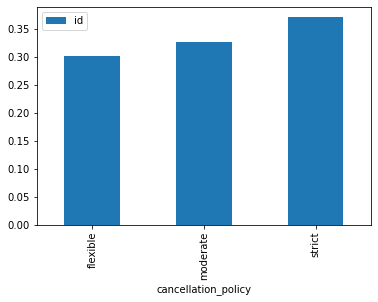

In [55]:
plot_dist('cancellation_policy')

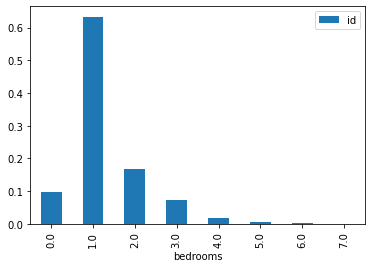

In [56]:
plot_dist('bedrooms')

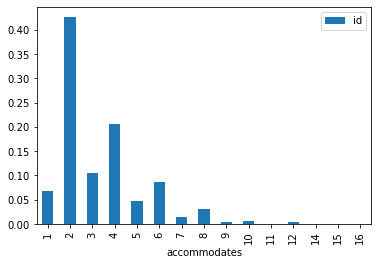

In [57]:
plot_dist('accommodates')

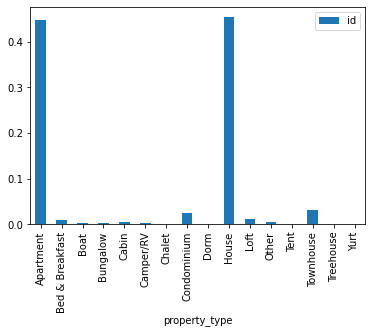

In [58]:
plot_dist('property_type')

Possible outcome columns related to price

In [60]:
out=['price', 'weekly_price', 'monthly_price']

In [61]:
dfm=df.loc[~df['monthly_price'].isnull()]
print(len(dfm))
dfw=df.loc[~df['weekly_price'].isnull()]
print(len(dfw))
print(len(df.loc[~df['price'].isnull()]))

1517
2009
3818


In Seattle the highest rental prices are in the summer, especially in June. The price change can be noticeable during the year. 

<AxesSubplot:xlabel='month'>

<Figure size 432x288 with 0 Axes>

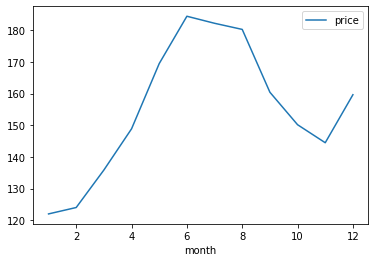

In [62]:
dfcal=dfcal[['id', 'month', 'price']].drop_duplicates()
mp = dfcal[['month', 'price']].groupby('month', as_index=False).mean()
plt.figure()
mp.plot(x='month', y='price')

Check which month has most postings

3623


<Figure size 432x288 with 0 Axes>

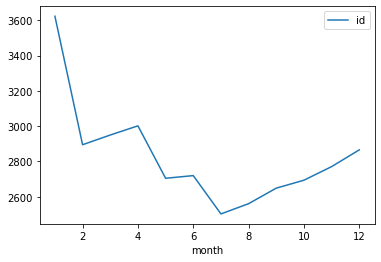

In [63]:
cp = dfcal[['month', 'id']].drop_duplicates().groupby('month', as_index=False).count()
plt.figure()
cp.plot(x='month', y='id')
print(cp['id'].max())

Process numerical features 

In [64]:
df['host_response_rate'] = df['host_response_rate'].apply(lambda x: float(str(x).replace('%', '')))
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x: float(str(x).replace('%', '')))
df['host_since'] = df['host_since'].apply(lambda x:  str(x)[-4:])
col_reviews=['number_of_reviews','review_scores_checkin', 'review_scores_communication', 'reviews_per_month','review_scores_value', 'review_scores_rating',  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location']


Numerical features

In [65]:
#This feature works better (checked) and reduce number of features
colf=df.select_dtypes(['float', 'int', 'int64']).columns
colf =[i for i in colf if i not in ['id','scrape_id']]
print(colf)
fill_mean = lambda col: col.fillna(int(col.mean()))
# Fill the mean
df[colf] = df[colf].apply(fill_mean, axis=0)
for i in col_reviews:
    df[i]=df[i].fillna(0.0)

['host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']


In [66]:
df["host_total_listings_count"]=df["host_total_listings_count"].fillna(df["host_total_listings_count"].mean())

In [67]:
#This feature works better (checked) and reduce number of features
df['totalrooms'] = df['bedrooms']+df['bathrooms']

In [68]:
#'host_listings_count' is also excluded beacause it is almost the same as "host_total_listings_count" and it gives the same result
df= df.drop(columns=['host_listings_count', 'scrape_id', 'host_id'])

In [69]:
cat_col = df.select_dtypes(include=['object']).columns
df[cat_col] = df[cat_col].fillna('none')
text=['experiences_offered', 'summary', 'amenities', 'name',  'notes', 'description', 'neighborhood_overview', 'transit', 'host_about']
exclude=['id', 'neighbourhood_group_cleansed', 'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col = [i for i in cat_col if i not in out+exclude+text]
print(cat_col)

['host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode', 'smart_location', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'jurisdiction_names', 'instant_bookable', 'cancellation_policy']


Split dataset on train and test before merging with calendar data frame to have postings ids splited.

In [70]:
del df['price']
df_train, df_test = train_test_split(df, test_size=0.2, random_state=41)  
df_train=pd.merge(df_train, dfcal, on ='id').drop_duplicates()
Y=df_train['price']
df_test=pd.merge(df_test, dfcal, on ='id').drop_duplicates()

In [72]:
col=df_train.select_dtypes(['float', 'int', 'int64']).columns
#excluded also 'host_listings_count' beacause it is almost the same as "host_total_listings_count" and it gives the same result
col =[i for i in col if i not in ['id', 'scrape_id', 'host_listings_count']]

 Heat map to find which features are high correlated and may not be be used all together. We will use light gradient boosting for further features selection. All this will be also checked on final resulst optimization.

/var/folders/dl/4wf0xf5x4w1gxvpmbsyrqfl00000gn/T/ipykernel_36192/619263054.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

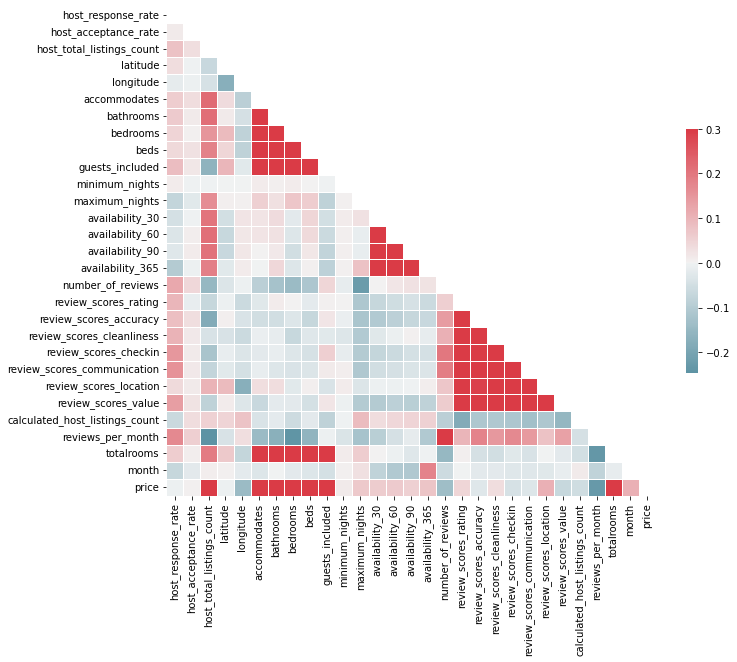

In [73]:
#first to exclude 
#col = [i for i in col if i not in exc]
corr = df_train[col].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Split data frame before merging the calendar, to have spliting by ids.

In [ ]:
#some columns will be in exc in case they are needed later
exc=  ['id', 'maximum_nights', 'price']#['calculated_host_listings_count', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',  'review_scores_cleanliness', 'host_listings_count', "price"]
col = [i for i in col if i not in exc]
print(col)
#col = ['host_response_rate', 'latitude', 'longitude', 'accommodates', 'month', 'totalrooms', 'number_of_reviews', 'availability_365', 'availability_60', 'review_scores_rating', 'minimum_nights', 'host_total_listings_count']
X_num=df_train[col]
Y=df_train["price"]
Y_test=df_test["price"]
X_test=df_test[col]
print(len(col))
#model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=32, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
model=RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
score, test_score, y_pred = model_eval(X_num, Y, X_test, Y_test, model)
print('all')
print('numerical train crossvalidation')
print(np.mean(score))
print('numerical test')
print(test_score)

['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'totalrooms', 'month']
27


In [ ]:
#remove lowest importance values and some of highly correlated, until we have the best result at the end
exc=  ['beds', 'number_of_reviews', 'bathrooms', 'availability_30', 'bedrooms', 'calculated_host_listings_count', 'host_id','maximum_nights', 'host_location' ,'host_acceptance_rate', 'calculated_host_listings_count',  'review_scores_checkin', 'price', 'review_scores_value', 'availability_60', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_communication', 'review_scores_accuracy',   "price"]
col1 = [i for i in col if i not in exc]
print(col1)
X_num=df_train[col1]
X_test = df_test[col1]
#model
#model_num = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=32, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#XGBClassifier(max_depth=5, learning_rate=0.01,  sample_weight=w_array)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
model_num=RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
score, test_score, y_pred = model_eval(X_num, Y, X_test, Y_test, model_num)
print('selected features')
print('numerical cross validation')
print(np.mean(score))
print('numerical test')
print(test_score)

In [ ]:
#ax = lgb.plot_importance(model, max_num_features=26)
#plt.show()
plot_rf_features(X_num, model_num)

In [ ]:
df=df.drop(['experiences_offered'], axis=1)

Categorical features encoding

In [ ]:
le  = LabelEncoder()
for i in cat_col:
    df_train[i]=le.fit_transform(df_train[i].astype('category'))
    df_test[i]=le.fit_transform(df_test[i].astype('category'))
Xtrain_cat = df_train[cat_col]
Xtest_cat = df_test[cat_col]

All together with lowest importance values removed

In [ ]:
exclude=['id', 'host_location', 'cancellation_policy', 'neighbourhood', 'smart_location', 'has_availability', 'requires_license', 'jurisdiction_names', 'instant_bookable',  'host_is_superhost',  'bed_type',  'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col =[i for i in cat_col if i not in exclude]
print(cat_col)
#model
X=df_train[cat_col+col1]
X_test = df_test[cat_col+col1]
model=RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
#cross_val
score, test_score, y_pred1 = model_eval(X, Y, X_test, Y_test, model)
model_lgb = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =8)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#cross_val
#score, test_score, y_pred = model_eval(X, Y, X_test, Y_test, model)
print('numerical and categorical features together')
print('crossvalidation')
print(np.mean(score))
print('test')
print(test_score)

score, test_score, y_pred = model_eval(X, Y, X_test, Y_test, model_lgb)
print('numerical and categorical features together LGB')
print('crossvalidation')
print(np.mean(score))
print('test')
print(test_score)


In figures below the feature importance in Random Forest and Light Gradient Boosting is shown after removing weakest features that improved cross validation test result

In [ ]:
#ax = lgb.plot_importance(model, max_num_features=26)
#plt.show()
plot_features(X, model, "Random Forest")

In [ ]:
plot_features(X, model_lgb, " Light Gradient Boosting")

Text features processing

In [ ]:
X_train_desc, X_test_desc, count_descp = tfidf_text_transform(df_train["description"], df_test["description"], 130)
X_train_name, X_test_name, count_name = tfidf_text_transform(df_train["name"], df_test["name"], 130)
X_train_transit, X_test_transit, count_transit = tfidf_text_transform(df_train["transit"], df_test["transit"], 70)
X_train_am, X_test_am, count_am = tfidf_text_transform(df_train['amenities'], df_test['amenities'], 20)
X_train_s, X_test_s, count_s = tfidf_text_transform(df_train['summary'], df_test['summary'], 20)
n=10
most_popular_words(count_descp, X_train_desc, n)
most_popular_words(count_name, X_train_name, n)
most_popular_words(count_transit, X_train_transit, n)
most_popular_words(count_s, X_train_s, n)


Adding text feature to previous model did not improved result. Too many features can result to overfitting and text features work better with different LGB parameters. As the result the best final R2 test score is 0.736

In [ ]:
X1=hstack((              
                         X_train_s,
                         X_train_am,
                         X_train_transit,      
                         X_train_name,
                         X_train_desc
          )).tocsr()
X_test1=hstack((         
                         X_test_s,
                         X_test_am,
                         X_test_transit,      
                         X_test_name,
                         X_test_desc
          )).tocsr()
model_text = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.3, num_leaves=31, max_depth = 8)
score1, test_score1, ypred_text = model_eval(X1, Y, X_test1, Y_test, model_text)
#X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2, random_state=42)
print('score on text features')
#print(score)
print(np.mean(score1))
print('cross validation score')
print(test_score1)
y_predf = 0.8*y_pred+0.2*ypred_text
score = r2_score(Y_test, y_predf)
print('superposition of models')
print(score)